## Load packages, data, and parameters

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
from scipy import interpolate

## Numerical factors
pi2   = 2.*np.pi
pi4   = 4.*np.pi
pi8   = 8.*np.pi
sq8   = np.sqrt(pi8)

## Physical constants
hbar  = 6.582119569e-19 # Planck's constant  [keV s]
cs    = 2.99792458e10   # speed of light     [cm/s]
hbarc = hbar*cs         #                    [keV*cm]
me    = 511.            # Electron mass      [keV]
RSun  = 6.9634e10       # Solar radius       [cm]
Rt    = 0.7*RSun        # Tachocline radius  [cm]
dSun  = 1.5e13          # Earth-Sun distance [cm]
mPl   = 1.221e25/sq8    # Planck mass        [keV]
alpha = 1./137.036      # Fine-structure constant

## Conversion units
pc    = 3.086e18     # cm
gkeV  = 1.782662e-30 # conversion from g to keV
year  = 3.15e7       # conversion from year to s
NXe   = 4.58644e21   # Number of Xe atoms per g
conv  = 10**6*year   # conversion from (g*s)^-1 to (year*ton)^-1
tXE   = 1.042e6      # XENON1T target in g

### Solar Parameters 

In [5]:
## Values at tachocline
xt    = 0.7             # Relative position 
Bt    = 0.021           # Solar magnetic field    [keV^2]
rhot  = 891921.86598    # Plasma density          [keV^4]
TSun  = 0.1995759863    # Temperature             [keV]
ne    = 1.06051586e+23  # Electron number density [cm^-3]
lam   = 0.3             # Photon mean free path   [cm]
ng    = 1.e21           # Photon flux [s^-1 cm^-2; Eq.32 in 1110.2583]
Dx    = 0.01            # Thickness of the tachocline

## Values at Sun core
rhoc   = 6.5e8  # Plasma density  [keV^4]
Tcore  = 1.3    # Temperature     [keV]

### Experimental Detectors Parameters

In [6]:
## total exposure
eX1T = 0.65 # XENON1T exposure for 1042kg Xe for 226.9days
eXnT = 20   # Projected exposure for XENONnT
eP4T = 5.6  # Projected exposure for PandaX-4T
eLZ  = 15   # Projected exposure for LZ

# Total mass at detectors
MX1T = 1.042 # Active mass of XENON1T
MXnT = 3.
MP4T = 2.8
MLZ  = 5.6

In [7]:
## Define the location of the files containing the data from XENON1T
## NOTE: xd, xs are in keV!!!
# data_path = "../data/"
data_path = "/home/yuangw/Documents/GitHub/Chameleons/XENONCHAM_2103.15834/data/"
fC = data_path+'Central.csv'
fL = data_path+'Lower.csv'
fU = data_path+'Upper.csv'
fS = data_path+'Signal.csv'
fE = data_path+'efficiency.csv'
fs = data_path+'sigmaevsE.txt'

## Read the XENON1T data and define the central deviation
xd, yC = np.loadtxt(fC, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
xd, yL = np.loadtxt(fL, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
xd, yU = np.loadtxt(fU, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
yL = yC-yL
yU = yU-yC
sigD = (yU-yL)/2.
sigD = np.array([yL,yU])

# Define the function giving the XENON1T background vs energy in keV
enb, backb = np.loadtxt(fS, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
back = interpolate.interp1d(enb, backb, fill_value=(0.0, 0.0), bounds_error=False)

# Define the efficiency of the XENON1T detector vs energy in keV
# See the XENON paper 2006.09721 Fig.2 
ekeV, eff = np.loadtxt(fE, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
epsilon   = interpolate.interp1d(ekeV, eff, fill_value=(0.,0.89), bounds_error=False)


In [8]:
# Energy resolution; sgm is from XENON paper 2006.09721 Eq.1; om in keV
def res_sgm(omR, om):
    sgm = 0.31*np.sqrt(omR) + 0.0037*omR # in keV
    return np.exp(-0.5*(om-omR)**2/sgm**2)/np.sqrt(pi2)/sgm
res_sgm = np.vectorize(res_sgm)

# Plasma frequency squared at the tachocline in keV^2
omPl2 = pi4*alpha*ne*hbarc**3/me

# chameleon mass squared in keV^2
# Eq.3-4 in 1110.2583
def mphi2(ge, gc, n):
    phim = (n*mPl*10**((4.+n)*gc-ge)/rhot)**(1./(1.+n))
    return (1.+n)*10**ge*rhot/mPl/phim

# Function accounting for the conversion length of a chameleon at tachocline, 2103.15834 Eq.B12 
def Int(a):
    return np.sqrt(np.pi/2.)*(np.sqrt(a + np.sqrt(a**2+4.)) - np.sqrt(2.*a))

## logMg = Log10[M_gamma/keV]
def bg2(logMg):
    return Bt**4/10**(8.*logMg)


In [9]:
# Eq.24 in 1505.01020
# returns keV
def DeltaB(gg, logMg):
    return 2.*10**gg*Bt/mPl/np.sqrt(1.+bg2(logMg) )

# Eq.22 in 1505.01020
# returns keV
def DeltaPl(om):
    return 0.5*omPl2/om

# Eq.23 in 1505.01020
# returns keV
def Delta_a(om, ge, gc, n, logMg):
    temp = mphi2(ge, gc, n)/2./om + bg2(logMg)*om*(2./3.)
    return temp/(1.+ bg2(logMg) )

# Denominator in Eq.25 of 1505.01020
# returns keV^2
def DEN(om, ge, gg, gc, n, logMg):
    return 4.*DeltaB(gg, logMg)**2 + (DeltaPl(om) - Delta_a(om, ge, gc, n, logMg))**2


In [10]:
# Eq.43 in 1110.2583
# om is in keV
# returns cm
def lom(om, ge, gg, gc, n, logMg):
    return 2.*hbarc/np.sqrt(DEN(om, ge, gg, gc, n, logMg))

# Eq.31 in 1110.2583 
# pg is in keV^-1
def pg(om):
    return om**2/TSun**3/(np.exp(om/TSun)-1.)/2.404

# Eq.47 in 1110.2583
# Pcham is dimensionless
def Pcham(om, ge, gg, gc, n, logMg):
    lo = lom(om, ge, gg, gc, n, logMg)
    dd = DEN(om, ge, gg, gc, n, logMg)
    return Dx*np.sqrt(cs/lo)*RSun/lam*4.*DeltaB(gg, logMg)**2/dd*Int(lo/lam)

# Eq.48 in 1110.2583
# Returns the differential flux at Earth in cm^-2 s^-1 keV^-1
def dPhidomega_cham(om, ge, gg, gc, n, logMg):
    return ng*pg(om)*Pcham(om, ge, gg, gc, n, logMg)*(Rt/dSun)**2/4.


In [11]:
## DETECTION
##

## Disformal cross section at detection in cm^2/g
def sigma_cham_dis(om, logMe): # om in keV
    return 0.5*NXe*(hbarc*me*om**2/pi2/10**(4.*logMe))**2

# photoelectric cross section in cm^2/g vs energy in keV
EMeV, sigme = np.loadtxt(fs, dtype='f8', delimiter = ',', usecols=(0,1), unpack=True)
sigmae = interpolate.interp1d(EMeV*1.e3, sigme, fill_value=(sigme[0],0), bounds_error=False)

## Absorption cross section at detection in cm^2/g
def sigma_cham_abs(om, ge): # om in keV
    return (10**ge*om/mPl)**2*sigmae(om)*4./alpha

## Total cross section at detection in cm^2/g
def sigma_cham(om, ge, logMe): # om in keV
    # return sigma_cham_dis(om, logMe) + sigma_cham_abs(om, ge)
    return sigma_cham_abs(om, ge)

In [12]:
####
## We multiply dPhidomega_cham * sigma_cham * conv
## dPhidomega_cham [cm^-2 s^-1 keV^-1]
## sigma_cham [cm^2/g]
## conv       [s*g*(year*ton)^-1]
## So Rate = year^-1*ton^-1*keV^-1 as in 2006.09721 Fig.3
####

# Rate before convolution
# Input energy is om in keV
# Output rate is in year^-1*ton^-1*keV^-1
def Rate_bare_cham(om, ge, gg, gc, n, logMe, logMg):
    ret = 0
    if om > 0:
      ret = np.nan_to_num(conv*sigma_cham(om, ge, logMe)*dPhidomega_cham(om, ge, gg, gc, n, logMg))
    return ret
Rate_bare_cham = np.vectorize(Rate_bare_cham)

def Rate_cham(om, ge, gg, gc, n, logMe, logMg):
    omp = np.geomspace(0.01, 10.0, 100)
    omX = Rate_bare_cham(omp, ge, gg, gc, n, logMe, logMg)
    cnv = epsilon(om)*np.trapz(res_sgm(omp, om)*omX, omp)
    return cnv
Rate_cham = np.vectorize(Rate_cham)


1.9018120367987057e-22


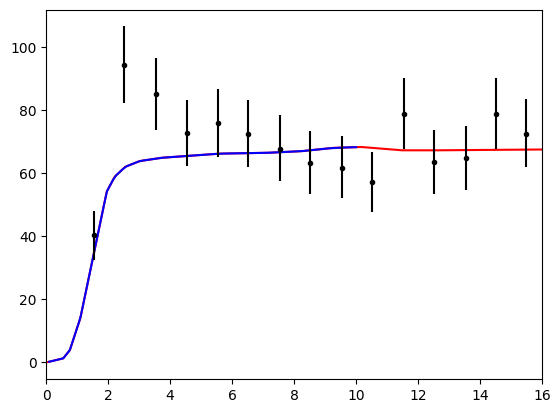

In [13]:
### Values chosen for the MCMC
### n_in is the exponent of the potential
### gc_in = Log10(Lambda/eV) where Lambda^4 is the DE energy density
n_in  =  1.
gc_in = -3. # fix Lambda = 1meV

### Starting points of the MCMC
logMe0 = 3.67
logMg0 = 0.
ge0    = 0.
gg0    = 9.5

omp = np.geomspace(0.1, 10.0, 100)
cnv = Rate_cham(omp, ge0, gg0, gc_in, n_in, logMe0, logMg0)
Nexp = eX1T*np.trapz(cnv, omp)
print(Nexp)

omp = np.geomspace(0.1, 10.0, 100)
bk  = back(omp)
cnv = bk + Rate_cham(omp, ge0, gg0, gc_in, n_in, logMe0, logMg0)
plt.plot(enb, backb,   'r-')
plt.plot(omp, cnv, 'b-')
plt.errorbar(xd, yC, yerr=sigD, xerr=None, fmt='.k')
plt.xlim((0., 16.))
#plt.xscale('log')
# plt.savefig('/home/yuangw/Documents/GitHub/Chameleons/flux.pdf', bbox_inches='tight')
plt.show()
